In [1]:
import sys
!{sys.executable} -m pip install --user --upgrade steam-nb-api

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines

from copy import *
from steam_nb_api.ledet.ParametersLEDET import ParametersLEDET
from steam_nb_api.utils import misc
from steam_nb_api.roxie_parser import MagneticCoil
from steam_nb_api.utils.SelfMutualInductanceCalculation import SelfMutualInductanceCalculation

from steam_nb_api.roxie_parser import CableDatabase
from steam_nb_api.roxie_parser import ConductorPosition
from steam_nb_api.roxie_parser.geometricFunctions import close_pairs_ckdtree, close_pairs_pdist

# Global variables

In [2]:
nameMagnet = 'MQY_8Coils'

# Define style for plots
selectedFont = {'fontname':'DejaVu Sans', 'size':14}
# If this variable is set to True, many comments will be displayed
verbose = True

# Generate magnet geometry parsing .data and .cadata files


VERSION 10.2.1
'LHC MQY, insertion quadrupole, 4.5K                                                '
'/eos/project/r/roxie/users/femurgia/datab/roxie.bhdata                             '
'/eos/project/r/roxie/users/femurgia/datab/roxie.cadata                             '
'/eos/project/r/roxie/users/femurgia/MQY/MQY_2D_Iron.iron                           '

&OPTION
  LEND=F     LWEDG=F    LPERS=T    LQUENCH=F  LALGO=F    LQUENCH0D=F
  LMIRIRON=F LBEMFEM=T  LPSI=F     LSOLV=F    LIRON=T    LMORPH=F   
  LHARD=F    LPOSTP=F   LPEAK=T    LINMARG=F  LMARG=F    LSELF=F    
  LMQE=F     LINDU=T    LEDDY=F    LSOLE=F    LFLUX=F    LFIELD3=F  
  LFISTR=F   LSELF3=F   LBRICK=F   LLEAD=F    LVRML=F    LOPERA=F   
  LOPER20=F  LANSYS=F   LRX2ANS=F  LANS2RX=F  LDXF=F     LMAP2D=T   
  LMAP3D=F   LEXPR=F    LFIL3D=F   LFIL2D=F   LCNC=F     LANSYSCN=F 
  LWEIRON=F  LCATIA=F   LEXEL=F    LQVOLT=F   LAXIS=T    LIMAGX=T   
  LIMAGY=T   LRAEND=F   LMARKER=F  LROLER2=F  LROLERP=F  LIMAGZZ=F  
  LSUPP=F  

<IPython.core.display.Javascript object>


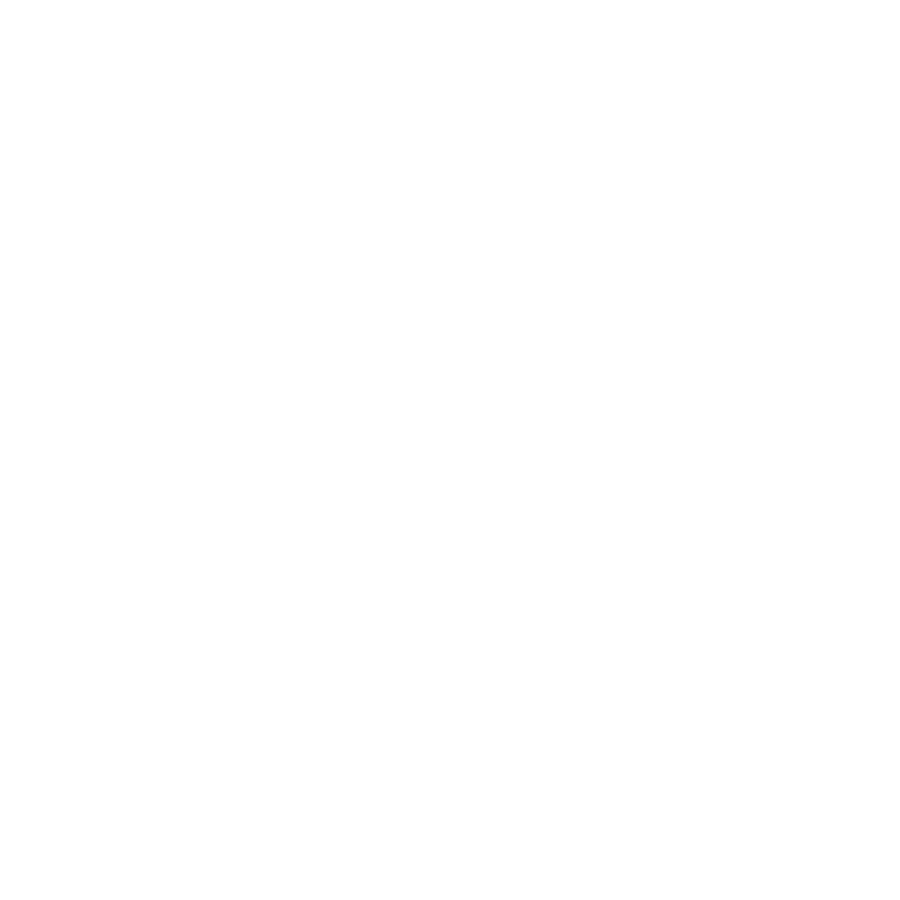

In [3]:
# Select ROXIE .cadata file with conductor data
currentDirectory = Path(os.path.split(os.getcwd())[0])
fileNameCadata = os.path.join(currentDirectory,'resources','roxie.cadata')
# fileNameCadata = 'roxie.cadata'
fileNameData = nameMagnet + '_All_WithIron_WithSelfField.data'

# Define the magnetic coil
definedMagneticCoil = MagneticCoil.MagneticCoil()
xPos, yPos, iPos, xBarePos, yBarePos, xS, yS, iS = definedMagneticCoil.generateCoilGeometry(fileNameData, fileNameCadata, verbose=verbose)

# Plot conductors and their numbers
%matplotlib notebook
f = plt.figure(2, figsize=(10, 10))
# Plot edges
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

    # Plot conductor numbers
    x_ave_cond, y_ave_cond = sum(cXPos) / len(cXPos), sum(cYPos) / len(cYPos)
    plt.text(x_ave_cond, y_ave_cond, '{}'.format(c + 1))

# Plot edges of bare conductors
for c, (cXBarePos, cYBarePos) in enumerate(zip(xBarePos, yBarePos)):
    pt1, pt2, pt3, pt4 = (cXBarePos[0], cYBarePos[0]), (cXBarePos[1], cYBarePos[1]), (cXBarePos[2], cYBarePos[2]), (
    cXBarePos[3], cYBarePos[3])
    if iPos[c] > 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='r', edgecolor='k', alpha=.25)
    elif iPos[c] < 0:
        line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=False, facecolor='b', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)

plt.xlabel('x [m]', **selectedFont)
plt.ylabel('y [m]', **selectedFont)
plt.title('Conductors and their numbers', **selectedFont)
plt.set_cmap('jet')
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.grid()
# f.savefig("Geometry_MQY.png", bbox_inches='tight', dpi=600)

# Field maps from ROXIE

Total number of strands in the field-map from ROXIE = 36032


<IPython.core.display.Javascript object>


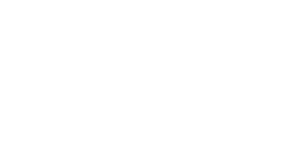

In [4]:
# Acquire data from ROXIE .map2d file
fileName = nameMagnet + '_All_WithIron_WithSelfField.map2d'
headerLines = 1

strandToGroup = np.array([])
strandToHalfTurn = np.array([])
idx = []
x = []
y = []
Bx = []
By = []
Area = []
I = []
fillFactor = []

# Read file
file = open(fileName, "r")
fileContent = file.read()

# Separate rows
fileContentByRow = fileContent.split("\n")

for index in range(len(fileContentByRow)-1):
    if index>headerLines:
        fc = fileContentByRow[index]
        row = fc.split()
       # print(index)
       # print(row)
        strandToGroup = np.hstack([strandToGroup,int(row[0])])
        strandToHalfTurn = np.hstack([strandToHalfTurn,int(row[1])])
        idx = np.hstack([idx,float(row[2])])
        x = np.hstack([x,float(row[3])/1000]) # in [m]
        y = np.hstack([y,float(row[4])/1000]) # in [m]
        Bx = np.hstack([Bx,float(row[5])])
        By = np.hstack([By,float(row[6])])
        Area = np.hstack([Area,float(row[7])])
        I = np.hstack([I,float(row[8])])
        fillFactor = np.hstack([fillFactor,float(row[9])])

nStrandsFieldMap = len(strandToGroup)
print('Total number of strands in the field-map from ROXIE = ' + str(nStrandsFieldMap))
# print (StrandToGroup)
# Calculate absolute magnetic field
B = []
for i in range(nStrandsFieldMap):
    B = np.hstack([B, (Bx[i]**2+By[i]**2)**.5 ])


# Plot strand currents and magnetic field

f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=I)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Strand currents',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Current per strand [A]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=Bx)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field X',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=By)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field Y',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field Y [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=B)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('From ROXIE: Magnetic field |B|',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Magnetic field [T]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()
# f.savefig("Magnetic field_MQY.png", bbox_inches='tight', dpi=600)

# Manipulate imported strand positions

Total number of strands = 36032
Total number of half-turns = 1184
Total number of turns = 592
Total number of groups = 80


<IPython.core.display.Javascript object>


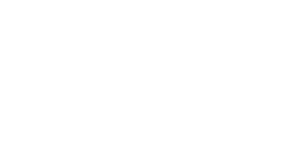

In [5]:
# Number of strands in each half-turn
nStrands = len(strandToGroup)
polarities = np.sign(I);
nHalfTurns = int(np.max(strandToHalfTurn));
nTurns = int(nHalfTurns/2)
nGroups = int(np.max(strandToGroup));
nS = []
for ht in range(1,nHalfTurns+1):
    #nS =sum(strandToHalfTurn==ht);
    nS = np.hstack([ nS, np.size(np.where(strandToHalfTurn==ht)) ]) # Number of strands in each half-turn
nS = np.int_(nS)

strandToGroup = np.int_(strandToGroup)
strandToHalfTurn = np.int_(strandToHalfTurn)
halfTurnToTurn=np.tile(np.arange(1,nTurns+1),2);

# Average half-turn positions
x_ave = []
y_ave = []
for ht in range(1,nHalfTurns+1):
    x_ave = np.hstack([ x_ave, np.mean( x[np.where(strandToHalfTurn==ht)] )])
    y_ave = np.hstack([ y_ave, np.mean( y[np.where(strandToHalfTurn==ht)] )])

# Average group positions
x_ave_group = []
y_ave_group = []
for g in range(1,nGroups+1):
    x_ave_group = np.hstack([ x_ave_group, np.mean( x[np.where(strandToGroup==g)] )])
    y_ave_group = np.hstack([ y_ave_group, np.mean( y[np.where(strandToGroup==g)] )])
    
print('Total number of strands = ' + str(nStrands))
print('Total number of half-turns = ' + str(nHalfTurns))
print('Total number of turns = ' + str(nTurns))
print('Total number of groups = ' + str(nGroups))


# Plot strand currents and magnetic field
%matplotlib notebook
f = plt.figure(figsize=(24,6))
plt.subplot(1, 4, 1 )
plt.scatter(x, y, s=2, c=strandToHalfTurn)
for ht in range(nHalfTurns):
    plt.text(x_ave[ht], y_ave[ht], '{}'.format(ht + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToHalfTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Half-turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x, y, s=2, c=strandToGroup)
for g in range(nGroups):
    plt.text(x_ave_group[g], y_ave_group[g], '{}'.format(g + 1))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('strandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x_ave, y_ave, s=2, c=halfTurnToTurn)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('halfTurnToTurn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Turn [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Number of strands per half-turn',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Number of  strands per cable [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Overall magnet variables

In [6]:
T00 = 4.5 # [K]

l_magnet = 3.4 #[m]

I00 = 3610 #[A] 


# Definition of groups of conductors

8 coil sections defined.
80 groups defined.


<IPython.core.display.Javascript object>


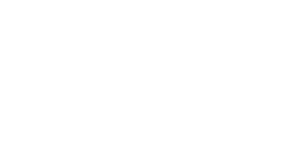

(-0.17727289977941177,
 0.17727289977941177,
 -0.07057289977941175,
 0.07057289977941175)

In [7]:

GroupToCoilSection = ([2,2,4,4,4,1,1,3,3,3,4,4,2,2,2,3,3,1,1,1,6,6,8,8,8,5,5,7,7,7,8,8,6,6,6,7,7,5,5,5])*2


polarities_inGroup =  [1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1] + [ -1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1,-1,-1,-1,-1,-1,1,1,1,1,1]

# Count number of groups defined
nCoilSectionsDefined = np.max(GroupToCoilSection)
nGroupsDefined = len(GroupToCoilSection)

print(str(nCoilSectionsDefined) + ' coil sections defined.')
print(str(nGroupsDefined) + ' groups defined.')

# print(GroupToCoilSection)
# print(polarities_inGroup)

# Plot defined current polarities
polarities_inStrand = np.zeros((1, nStrands), dtype=int)
polarities_inStrand = polarities_inStrand[0]
for g in range(1,nGroupsDefined+1):
    polarities_inStrand[np.where(strandToGroup==g)] = polarities_inGroup[g-1]
    
   

f = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(x, y, s=2, c=polarities_inStrand)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Defined polarities',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Polarity [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1,2,2)
plt.scatter(x_ave_group, y_ave_group, s=2, c=GroupToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Group To Coil Section',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')



# Conductor properties in each group

In [8]:
# Number of half-turns in each group
nT_G = [20, 17, 15, 6, 16]
nT = [20, 17, 15, 6, 16] * 16
# print(sum(nT))
print(sum(nT_G))
# Generate random half-turn number (for debugging)
nHalfTurnsDefined = np.sum(nT)
nHalfTurnsDefined_G = np.sum(nT_G)
print(str(nHalfTurnsDefined) + ' half-turns defined.')
print(nT_G)
nGroups_Out = 3
nGroups_Inn = 2

# Number of strands in each cable belonging to a particular group
#nStrands_inGroup = nHalfTurnsDefined * [40]

nStrands_inGroup = (nGroups_Out * [34] + nGroups_Inn* [22]) * 16
# print (len(nStrands_inGroup))
# print(nGroupsDefined)

# length of each half turn [m] (default=l_magnet)
l_mag_inGroup = nGroupsDefined * [l_magnet]
# strand diameter [m]
ds_inGroup = (nGroups_Out * [0.00048] + nGroups_Inn * [0.000735])*16

if len(ds_inGroup ) != nGroupsDefined:
    raise Exception('Variable ds_inGroup  should have nGroupsDefined elements. ds_inGroup  should have {} elements.'.format(nGroupsDefined))
    
# filament diameter [m]
df_inGroup = nGroupsDefined * [6E-6]
# fraction of superconductor in the strands
f_SC_strand_inGroup = (nGroups_Out* [1/(1+1.75)] +nGroups_Inn * [1/(1+1.25)]) *16
if len(f_SC_strand_inGroup) != nGroupsDefined:
    raise Exception('Variable f_SC_strand_inGroup should have nGroupsDefined elements. f_SC_strand_inGroup should have {} elements.'.format(nGroupsDefined))

# Effective transverse resistivity parameter (default=1)
f_ro_eff_inGroup = nGroupsDefined * [1]
# Filament twist-pitch [m]
Lp_f_inGroup = nGroupsDefined * [0.015]
# RRR of the conductor in each group of cables
RRR_Cu_inGroup = nGroupsDefined * [150]
# type of superconductor (1=Nb-Ti, 2=Nb3Sn, 3=BSCCO2212, 4=Nb3Sn with Bordini fit)
SCtype_inGroup = nGroupsDefined * [1]
# type of stabilizer (1=Cu, 2=Ag)
STtype_inGroup = nGroupsDefined * [1]
# Type of cable insulation (1=G10, 2=kapton)
insulationType_inGroup = nGroupsDefined * [2]
# Type of filler of voids between adjacent strands (1=G10, 2=kapton, 3=helium, 4=void)
internalVoidsType_inGroup = nGroupsDefined * [3]
# Type of filler of voids between strands and insulation layesrs (1=G10, 2=kapton, 3=helium, 4=void)
externalVoidsType_inGroup = nGroupsDefined * [2]
# bare average cable width [m]
wBare_inGroup = nGroupsDefined * [8.2834E-3]         
if len(wBare_inGroup) != nGroupsDefined:
    raise Exception('Variable wBare_inGroup should have nGroupsDefined elements. wBare_inGroup should have {} elements.'.format(nGroupsDefined))
# bare average cable height [m]
hBare_inGroup = (nGroups_Out * [0.8433E-3]+ nGroups_Inn * [1.27245E-3])*16                    
if len(hBare_inGroup) != nGroupsDefined:
    raise Exception('Variable hBare_inGroup should have nGroupsDefined elements. hBare_inGroup should have {} elements.'.format(nGroupsDefined))                                  
# insulation thickness in the width direction [m]
wIns_inGroup = nGroupsDefined * [0.0798E-3]
if len(wIns_inGroup) != nGroupsDefined:
    raise Exception('Variable wIns_inGroup should have nGroupsDefined elements. wIns_inGroup should have {} elements.'.format(nGroupsDefined))  
# insulation thickness in the height direction [m]
hIns_inGroup = nGroupsDefined * [0.0798E-3]
if len(hIns_inGroup) != nGroupsDefined:
    raise Exception('Variable hIns_inGroup should have nGroupsDefined elements. hIns_inGroup should have {} elements.'.format(nGroupsDefined))  
# Strand twist-pitch [m] Cable transposition in Arjan's file
Lp_s_inGroup = nGroupsDefined * [0.066]
if len(Lp_s_inGroup) != nGroupsDefined:
    raise Exception('Variable Lp_s_inGroup should have nGroupsDefined elements. Lp_s_inGroup should have {} elements.'.format(nGroupsDefined))  
# Cross-contact resistance [Ohm]
R_c_inGroup = nGroupsDefined * [10E-6]             
# Tc0_NbTi_ht_inGroup [K]
Tc0_NbTi_ht_inGroup = nGroupsDefined * [9.2]
# Bc2_NbTi_ht_inGroup [T]
Bc2_NbTi_ht_inGroup = nGroupsDefined * [14.5]
# c1_Ic_NbTi_inGroup [A]
c1_Ic_NbTi_inGroup = (nGroups_Out * [25941.2] + nGroups_Inn* [45910.4]) * 16
# c2_Ic_NbTi_inGroup [A/T]
c2_Ic_NbTi_inGroup = (nGroups_Out * [-2078.1] + nGroups_Inn* [-3680.0]) * 16
# Tc0_Nb3Sn [K]
Tc0_Nb3Sn_inGroup = nGroupsDefined * [0]
# Bc2_Nb3Sn [T]
Bc2_Nb3Sn_inGroup = nGroupsDefined * [0]
# Jc_Nb3Sn0 [A*T/m^2] Based on short-sample measurements
Jc_Nb3Sn0_inGroup = nGroupsDefined * [0]
#parameter used for Bordini's Nb3Sn fit
alpha_Nb3Sn_inGroup= nGroupsDefined *[0]

# Jc fit parameters - Based on Arjan's file  (same as MQS)
fitParameters_inGroup = np.array((nGroups_Out * [[9.2, 14.5, 754.420, -57.277, 2101.181, 1.361, 8350.450, 12.007]] + nGroups_Inn* [[9.2, 14.5, 2061.5, -156.4, 5741.5, 1.4, 22817.8, 12.0]]) * 16).transpose() 
# Jc fit type (only used for persistent-current calculation): 1= Jc=constant; 2= Nb-Ti Bottura; 3= Nb-Ti CUDI ; 4= Nb3Sn Summer
selectedFit_inGroup =  nGroupsDefined * [3]

print(str(nHalfTurnsDefined) + ' half-turns defined.')
print('')
if nHalfTurnsDefined != nHalfTurns:
        raise Exception('Number of half-turns defined by nT ({}) is different from the number of half-turns in the magnetic field map ({}).'.format(nHalfTurnsDefined,nHalfTurns))

#  Scale up or down the contribution of heat exchange through the short side of the cables (useful to change the insulation between coil layers
insulationBetweenLayers = 3.20E-4
insulationAroundCables = 1.60E-4
fScaling_Pex_AlongHeight_Defined = (2*insulationAroundCables)/(2*insulationAroundCables + insulationBetweenLayers)
print('fScaling_Pex_AlongHeight_Defined = ')
print(fScaling_Pex_AlongHeight_Defined)

74
1184 half-turns defined.
[20, 17, 15, 6, 16]
1184 half-turns defined.

fScaling_Pex_AlongHeight_Defined = 
0.5


# Electrical order of the half-turns


<img src="ElectricalScheme_2AP.PNG" width="750"/>

The half-turns of these pairs of groups will be connected electrically:
[[6, 46], [7, 47], [18, 58], [19, 59], [20, 60], [55, 15], [53, 13], [54, 14], [42, 2], [41, 1], [16, 56], [17, 57], [8, 48], [9, 49], [10, 50], [45, 5], [43, 3], [44, 4], [52, 12], [51, 11], array([26, 66]), array([27, 67]), array([38, 78]), array([39, 79]), array([40, 80]), array([75, 35]), array([73, 33]), array([74, 34]), array([62, 22]), array([61, 21]), array([36, 76]), array([37, 77]), array([28, 68]), array([29, 69]), array([30, 70]), array([65, 25]), array([63, 23]), array([64, 24]), array([72, 32]), array([71, 31])]


<IPython.core.display.Javascript object>


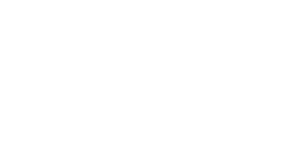

Calculated electrical order of the half-turns:
el_order_half_turns = [94, 686, 93, 685, 92, 684, 91, 683, 90, 682, 89, 681, 88, 680, 87, 679, 86, 678, 85, 677, 84, 676, 83, 675, 82, 674, 81, 673, 80, 672, 79, 671, 78, 670, 77, 669, 76, 668, 75, 667, 111, 703, 110, 702, 109, 701, 108, 700, 107, 699, 106, 698, 105, 697, 104, 696, 103, 695, 102, 694, 101, 693, 100, 692, 99, 691, 98, 690, 97, 689, 96, 688, 95, 687, 274, 866, 273, 865, 272, 864, 271, 863, 270, 862, 269, 861, 268, 860, 267, 859, 266, 858, 265, 857, 264, 856, 263, 855, 262, 854, 261, 853, 260, 852, 280, 872, 279, 871, 278, 870, 277, 869, 276, 868, 275, 867, 296, 888, 295, 887, 294, 886, 293, 885, 292, 884, 291, 883, 290, 882, 289, 881, 288, 880, 287, 879, 286, 878, 285, 877, 284, 876, 283, 875, 282, 874, 281, 873, 799, 207, 800, 208, 801, 209, 802, 210, 803, 211, 804, 212, 805, 213, 806, 214, 807, 215, 808, 216, 809, 217, 810, 218, 811, 219, 812, 220, 813, 221, 814, 222, 778, 186, 779, 187, 780, 188, 781, 189, 782, 190, 783, 

In [9]:
#electrical order: https://edms5.cern.ch/cdd/plsql/c4w.display_details?cookie=2242768&p_drob_id=607993&p_version=**
# Start and end indices of each group
indexTstop = np.cumsum(nT)
indexTstop = indexTstop.tolist()
indexTstart = [1]
for i in range(len(nT)-1):
    indexTstart.extend([indexTstart[i] + nT[i]])

# # Fake electrical order
# el_order_half_turns = []
# for i in range(1,nHalfTurnsDefined+1):
# el_order_half_turns.append(i)

# Calculation of the electrical order of the half-turns
# Pairs of groups whose half-turns are electrically connect (go and return lines)
elPairs_GroupTogether_A1 = [[6,46],[7,47],[18,58],[19,59],[20,60],[55,15],[53,13],[54,14],[42,2],[41,1],[16,56],[17,57],[8,48],[9,49],[10,50],[45,5],[43,3],[44,4],[52,12],[51,11]] 
nR=(np.int_(20))
elPairs_GroupTogether_A2=(elPairs_GroupTogether_A1+(nR))
# For each pair of groups, this flag determines whether the half-turns are electrically connected following LEDET order, or its inverse
elPairs_RevElOrder_A1=[1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0]
elPairs_RevElOrder_A2=[1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0]
# print(elPairs_GroupTogether_A1)
# print(elPairs_GroupTogether_A2)
elPairs_GroupTogether=elPairs_GroupTogether_A1
elPairs_GroupTogether.extend(elPairs_GroupTogether_A2)
# print(elPairs_GroupTogether)
elPairs_RevElOrder=elPairs_RevElOrder_A1
elPairs_RevElOrder.extend(elPairs_RevElOrder_A2)
# print(elPairs_RevElOrder)
nElPairs=len(elPairs_GroupTogether);
# Checks
if len(elPairs_GroupTogether) != nElPairs:
    raise Exception('Variable elPairs_GroupTogether should have nGroupsDefined elements. elPairs_GroupTogether should have {} elements.'.format(nElPairs))  

nElPairs=len(elPairs_GroupTogether);
print('The half-turns of these pairs of groups will be connected electrically:')
print(elPairs_GroupTogether)

if len(elPairs_RevElOrder)!=nElPairs:
    raise Exception('Length of the vector elPairs_RevElOrder ({}) must be equal to nElPairs={}.'.format(len(elPairs_RevElOrder),nElPairs))

el_order_half_turns=[];
for p in range(nElPairs):
    if nT[elPairs_GroupTogether[p][0]-1]!=nT[elPairs_GroupTogether[p][1]-1]:
        raise Exception('Pair of groups defined by the variable elPairs_GroupTogether must have the same number of half-turns.')
    for k in range(nT[elPairs_GroupTogether[p][0]-1]):
        if elPairs_RevElOrder[p]==0:
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][0]-1]+k );
            el_order_half_turns.append( indexTstart[elPairs_GroupTogether[p][1]-1]+k );
        if elPairs_RevElOrder[p]==1:
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][0]-1]-k );
            el_order_half_turns.append( indexTstop[elPairs_GroupTogether[p][1]-1]-k );

el_order_half_turns_Array = np.int_(el_order_half_turns)
elPairs_GroupTogether_Array = np.int_(elPairs_GroupTogether)



# # Plot
plt.figure(figsize=(20,8))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=2, c=np.argsort(el_order_half_turns_Array))
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Electrical order [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
#Plot
plt.subplot(1, 3, 2)
plt.plot(x_ave[el_order_half_turns_Array-1],y_ave[el_order_half_turns_Array-1],'k')
plt.scatter(x_ave, y_ave, s=2, c=nS)
plt.scatter(x_ave[el_order_half_turns_Array[0]-1], y_ave[el_order_half_turns_Array[0]-1], s=50, c='b', label='Positive lead')
plt.scatter(x_ave[el_order_half_turns_Array[-1]-1], y_ave[el_order_half_turns_Array[-1]-1], s=50, c='r', label='Negative lead')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')
plt.legend(loc='lower left')
# Plot
plt.subplot(1, 3, 3)
plt.plot(x_ave_group[elPairs_GroupTogether_Array[:,0]-1],y_ave_group[elPairs_GroupTogether_Array[:,0]-1],'b')
plt.scatter(x, y, s=2, c='k')
plt.scatter(x_ave_group, y_ave_group, s=10, c='r')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Electrical order of the groups (only go-lines)',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

print('Calculated electrical order of the half-turns:')
print('el_order_half_turns = {}'.format(el_order_half_turns))

# f.savefig("Electrical order_MQY.png", bbox_inches='tight', dpi=600)

# Cable geometry parameters

<class 'list'>
1184
1184
<class 'list'>
1184
<class 'list'>


<IPython.core.display.Javascript object>


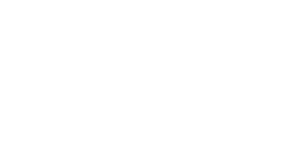

(-0.1784160755882353,
 0.1784160755882353,
 -0.0717160755882353,
 0.0717160755882353)

In [10]:
# Calculate group to which each strand belongs
# print(nHalfTurnsDefined_G)
nHalfQuadrant = 16
# Inclination of cables with respect to X axis (including transformations for mirror and rotation)
# alphasDEG = nHalfTurnsDefined * [0]
alphasDEG = nHalfQuadrant*[0,0.8974, 1.7948,2.6922,3.5895, 4.4869,5.3843, 6.2817,7.1791,8.0765,8.9739, 9.8712, 10.7686, 11.6660, 12.5634, 13.4608,14.3582,15.2556,16.1529,17.0503,0,0.8974,1.7948,2.6922,3.5895,4.4869,5.3843,6.2810,7.1791,8.0765,8.9739,9.8712,10.7686,11.666,12.5634,13.4608,14.3582, 0,0.8974,1.7948,2.6922,3.5895,4.4869,5.3843,6.2817,7.1791,8.0765,8.9739,9.8712,10.7686,11.666,12.5634,17.2500,18.9756,20.7013,22.4269,24.1526,25.8782,0,1.7256,3.4513,5.1769,6.9026,8.6282,10.3539,12.0795,13.8052,15.5308,17.2565,18.9821,20.7078,22.4334,24.1590,25.8847]
# print(nHalfQuadrant)
# print(nHalfTurns)
print(type(alphasDEG))
print(len(alphasDEG))
# Rotate cable by a certain angle [deg]
# rotation_block = nHalfTurnsDefined * [0]
rotation_block =(nHalfTurnsDefined_G*[0]+ nHalfTurnsDefined_G*[90]+ nHalfTurnsDefined_G*[180]+ nHalfTurnsDefined_G*[270])*4
# print(rotation_block)
print(len(rotation_block))
print(type(rotation_block))
# Mirror cable along the bisector of its quadrant (0=no, 1=yes)
# mirror_block = nHalfTurnsDefined * [0]
mirror_block = (nHalfTurnsDefined_G*[0]*8+nHalfTurnsDefined_G*[1]*8);
# print(mirror_block)
print(len(mirror_block))
print(type(mirror_block))            
# Mirror cable along the Y axis (0=no, 1=yes)
# mirrorY_block = nHalfTurnsDefined * [0]
mirrorY_block = nHalfTurns * [0]

alphasDEG_Array=np.array(alphasDEG)
rotation_block_Array= np.array(rotation_block)
  

f = plt.figure(figsize=(24,3))
plt.subplot(1, 3, 1)
plt.scatter(x_ave, y_ave, s=1, c=alphasDEG_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Inclination of cables',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Inclination [\xb0]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


plt.subplot(1, 3, 2)
plt.scatter(x_ave, y_ave, s=1, c=rotation_block_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Rotation Block',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Rotation Degrees [\xb0]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')



plt.subplot(1, 3, 3)
plt.scatter(x_ave, y_ave, s=2, c=mirror_block)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Mirror cable along the bisector',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Mirror Block[-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


# Heat exchange between half-turns

In [11]:
# Pairs of half-turns exchanging heat along the cable wide side
iContactAlongWidth_From = []
iContactAlongWidth_To = []

for g in range(nGroupsDefined):
    iContactAlongWidth_From.extend( range(indexTstart[g], indexTstop[g]) )
    iContactAlongWidth_To.extend( range(indexTstart[g]+1, indexTstop[g]+1) )

print('Heat exchange along the cable wide side - Calculated indices:')
print('iContactAlongWidth_From = ')
print(iContactAlongWidth_From)
print('iContactAlongWidth_To = ')
print(iContactAlongWidth_To)

Heat exchange along the cable wide side - Calculated indices:
iContactAlongWidth_From = 
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 201, 202, 203, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21


#Heat exchange between half-turns along the cable narrow side

Heat exchange along the cable narrow side - Calculated indices:
iContactAlongHeight_From = 
[1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12, 12, 13, 13, 13, 13, 14, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 28, 28, 28, 29, 29, 29, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33, 34, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 38, 38, 38, 38, 38, 39, 39, 40, 40, 40, 41, 41, 42, 42, 42, 43, 43, 44, 44, 45, 45, 45, 46, 46, 47, 47, 47, 48, 48, 49, 49, 50, 50, 50, 51, 51, 52, 52, 52, 53, 53, 54, 54, 54, 55, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 75, 75, 75, 75, 76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 78, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 84, 84, 84, 85, 85, 85, 85, 86, 86, 86, 86, 87, 87, 87, 87, 88, 88, 88, 88, 89, 89,

<IPython.core.display.Javascript object>


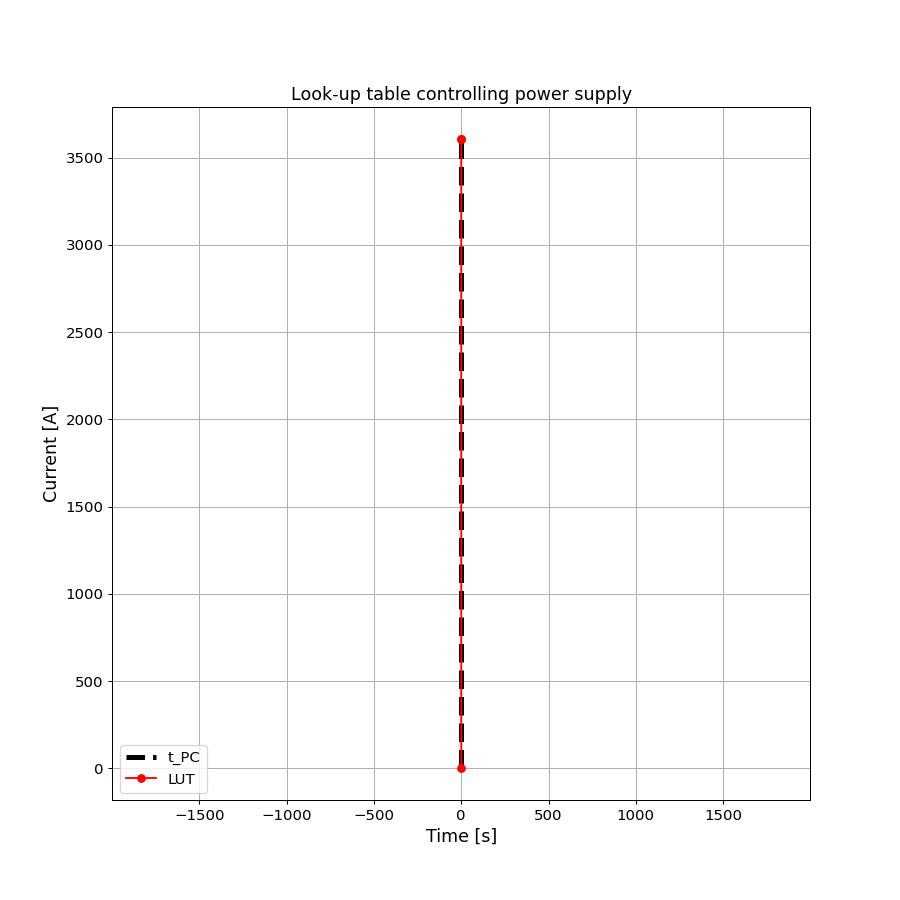

(-0.1832158598702951,
 0.1832158598702951,
 -0.07651585987029509,
 0.07651585987029509)

In [12]:
# This code will automatically find the half-turns that touch along the cable narrow side
# Half-turns will be thermally linked if:
# - they do not belong to the same conductor group, and
# - at least one strand of one half-turn is closer than max_distance to at least one strand of the other half-turn
# The code eliminates double repetition and orders the indices

# Prepare input for the function close_pairs_ckdtree
max_distance = 1.7E-3
X = np.column_stack((x, y))

# find all pairs of strands closer than a distance of max_d
pairs_close = close_pairs_ckdtree(X, max_distance)

# find pairs that belong to half-turns located in different groups
contact_pairs = set([])
for p in pairs_close:
    if not strandToGroup[p[0]] == strandToGroup[p[1]]:
        contact_pairs.add((strandToHalfTurn[p[0]],strandToHalfTurn[p[1]]))

# assign the pair values to two distinct vectors
iContactAlongHeight_From = []
iContactAlongHeight_To = []
for p in contact_pairs:
    iContactAlongHeight_From.append(p[0])
    iContactAlongHeight_To.append(p[1])

# find indices to order the vector iContactAlongHeight_From
idxSort = [i for (v, i) in sorted((v, i) for (i, v) in enumerate(iContactAlongHeight_From))]

# reorder both iContactAlongHeight_From and iContactAlongHeight_To using the indices
iContactAlongHeight_From = [iContactAlongHeight_From[i] for i in idxSort]
iContactAlongHeight_To = [iContactAlongHeight_To[i] for i in idxSort]

print('Heat exchange along the cable narrow side - Calculated indices:')
print('iContactAlongHeight_From = ')
print(iContactAlongHeight_From)
print('iContactAlongWidth_To = ')
print(iContactAlongHeight_To)


# Plot
iContactAlongHeight_From_Array = np.int_(iContactAlongHeight_From)
iContactAlongHeight_To_Array = np.int_(iContactAlongHeight_To)
iContactAlongWidth_From_Array = np.int_(iContactAlongWidth_From)
iContactAlongWidth_To_Array = np.int_(iContactAlongWidth_To)

%matplotlib notebook
f=plt.figure(figsize=(10,10))
# plot strand positions
plt.scatter(x, y, s=2, c='b')
# plot conductors
for c, (cXPos, cYPos) in enumerate(zip(xPos, yPos)):
    pt1, pt2, pt3, pt4 = (cXPos[0], cYPos[0]), (cXPos[1], cYPos[1]), (cXPos[2], cYPos[2]), (cXPos[3], cYPos[3])
    line = plt.Polygon([pt1, pt2, pt3, pt4], closed=True, fill=True, facecolor='r', edgecolor='k', alpha=.25)
    plt.gca().add_line(line)
# plot average conductor positions
plt.scatter(x_ave, y_ave, s=10, c='r')
# plot heat exchange links along the cable narrow side
for i in range(len(iContactAlongHeight_From)):
    plt.plot([x_ave[iContactAlongHeight_From_Array[i]-1],x_ave[iContactAlongHeight_To_Array[i]-1]], [y_ave[iContactAlongHeight_From_Array[i]-1],y_ave[iContactAlongHeight_To_Array[i]-1]] ,'k')
# plot heat exchange links along the cable wide side
for i in range(len(iContactAlongWidth_From)):
    plt.plot([x_ave[iContactAlongWidth_From_Array[i]-1],x_ave[iContactAlongWidth_To_Array[i]-1]], [y_ave[iContactAlongWidth_From_Array[i]-1],y_ave[iContactAlongWidth_To_Array[i]-1]] ,'r')
# plot strands belonging to different conductor groups and closer to each other than max_distance
# for p in pairs_close:
#     if not strandToGroup[p[0]] == strandToGroup[p[1]]:
#         plt.plot([X[p[0], 0], X[p[1], 0]], [X[p[0], 1], X[p[1], 1]], c='g')
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange order of the half-turns',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

# f.savefig("HeatExchange_MQY.png", bbox_inches='tight', dpi=600)

# Quench initiation calculation: Force selected half-turns to quench¶

In [13]:
# Choose one of the two following options: Fully 2D model, or Experimental 2D+1D model

# # # # Fully 2D model
# # Indices of the half-turns that are set to quench at a given time
# iStartQuench = [100]
# # Time at which each selected half-turn quenches [s]
# tStartQuench = [-0.015]
# # Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
# lengthHotSpot_iStartQuench = [l_magnet]
# # Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
# vQ_iStartQuench = [99999]

# # # Experimental 2D + 1D model
# In this example, only one half-turn is quenched (#100). When it quenches at time tStartQuench, the half-turn electrical resistance will be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When the quench propagates to the three adjacent half-turns (#97-99), their resistances will also be calculated using an initial quenched length of lengthHotSpot_iStartQuench, increasing with velocity vQ_iStartQuench
# When any other half-turn in the model quenches, its resistance will be calculated using the full magnetic length.
# Indices of the half-turns that are set to quench at a given time
iStartQuench = [1]
# Time at which each selected half-turn quenches [s]
tStartQuench = [9999]
# Length of the initial hot-spot [m] (it can be set to a large value to implement a full 2D model)
lengthHotSpot_iStartQuench = [10E-3]
# Quench propagation velocity [m/s] (you can write 2x higher velocity if the quench propagates in two directions)
vQ_iStartQuench = [9999]

# Electrical circuit during powering transient
<img src="LEDET_CircuitSchematic_Powering.png" width="750"/>


# Electrical circuit during protection transient
<img src="LEDET_CircuitSchematic_Protection.png" width="750"/>

# Circuit warm resistance and power-supply crowbar

In [14]:

# Resistance of the warm parts of the circuit [Ohm]
R_circuit = 0.00080
# Resistance of crowbar of the power supply [Ohm]
R_crowbar = 0.00002
# Forward voltage drop of a diode or thyristor in the crowbar of the power supply [V]
Ud_crowbar = 0.55

# Power supply control

In [15]:
# Time when the power supply is switched off and the crowbar is switched on [s]
t_PC = 0
# LUT controlling power supply, Time [s]
t_PC_LUT = [-0.02, t_PC, t_PC+0.01]
# LUT controlling power supply, Current [A]
I_PC_LUT = [I00, I00, 0]

# Plot
plt.plot([t_PC,t_PC], [np.min(I_PC_LUT),np.max(I_PC_LUT)], 'k--', linewidth=4.0, label='t_PC')
plt.plot(t_PC_LUT, I_PC_LUT, 'ro-', label='LUT')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Current [A]',**selectedFont)
plt.title('Look-up table controlling power supply',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='lower left')

# Energy-extraction system

In [16]:
# Time when the energy-extraction system is triggered [s]
tEE = 99999
# Resistance of the energy-extraction system [Ohm]
R_EE_triggered = 0.0375

# CLIQ system

In [17]:
# Time when the CLIQ system is triggered [s]
tCLIQ = 99999
# Direction of the introduced current change for the chosen CLIQ configuration
directionCurrentCLIQ = [1,1,-1,-1,1,1,-1,-1]
print(nCoilSectionsDefined)
# Number of CLIQ units
nCLIQ = 1
# CLIQ charging voltage [V]
U0 = 1000
# Capacitance of the CLIQ capacitor bank [F]
C = 0.04
# Resistance of the CLIQ leads [Ohm]
Rcapa = 0.03

8


# Quench heater system

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


<IPython.core.display.Javascript object>


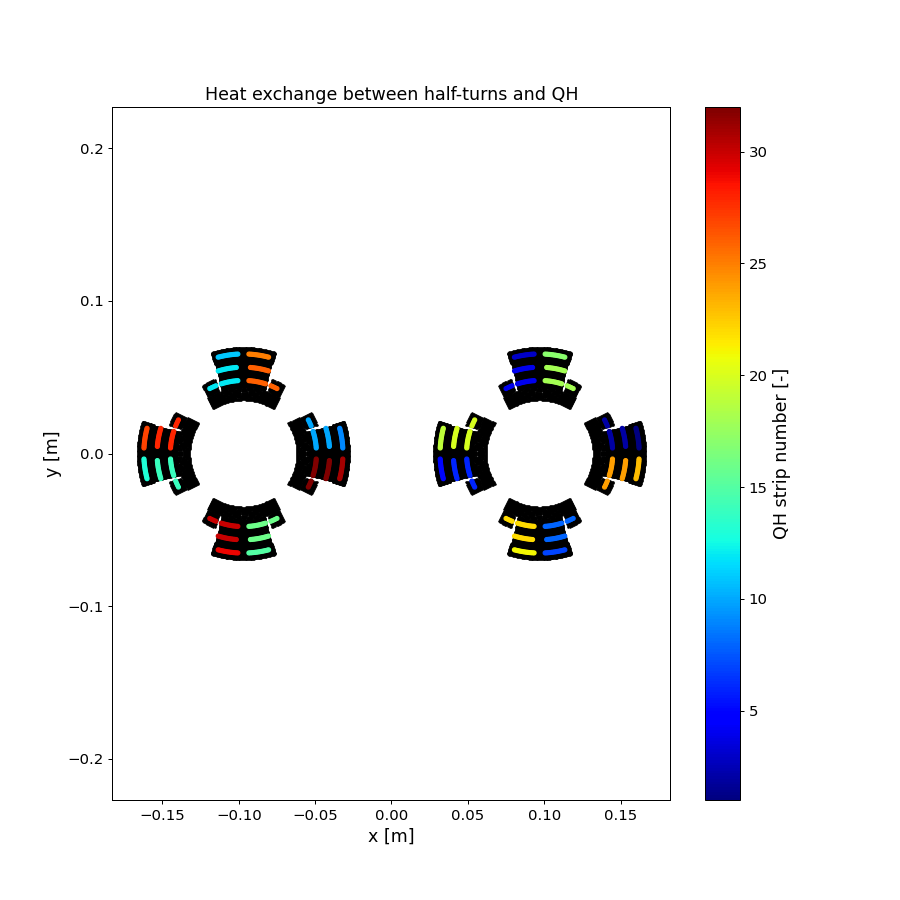

iQH_toHalfTurn_From = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

In [18]:
### Number of quench heater strips to write in the file
nHeaterStrips = 16
# Values for one OL and one IL QH strip, then copied nHeaterStrips times
# Time at which the power supply connected to the QH strip is triggered (set to a very large value to avoid triggering).                             
tQH = [2.0E-3, 2.0E-3] 
# Charging voltage of the capacitor connected to the QH strip.U=450V*2=900V
U0_QH = [900/8, 900/8]
# Capacitance of the capacitor connected to the QH strip. 
C_QH = [7.05E-3*8, 7.05E-3*8]  
# Resistance of the warm leads of the QH strip discharge circuit.
R_warm_QH = [1/8, 1/8] 
# Width of the non-Cu-plated part of the the QH strip.
w_QH = [15E-3, 21E-3]
# Height of the non-Cu-plated part of the QH strip.
h_QH = [25E-6, 25E-6]  
# Thickness of the insulation layer between QH strip and coil insulation layer.                       
s_ins_QH = [75E-6, 75E-6]   
# Thickness of the insulation layer between QH strip (or the collars); on this side, the QH strip is thermally connected to an infinite thermal sink at constant temperature.
s_ins_QH_He = [5E-4, 5E-4] 
# Length of the QH strip. 
l_QH = [l_magnet, l_magnet]
# Fraction of QH strip covered by heating stations (not-Cu-plated).Lss=100[mm], Lcu=250[mm]
f_QH = [100/(100+250), 130/(130+190)]
# Type of materialof the insulation layer between QH strip and coil insulation layer (1=G10; 2=kapton)
type_ins_QH = (nHeaterStrips*[2])*2
# Type of material of the insulation layer between QH strip and helium bath (1=G10; 2=kapton)
type_ins_QH_He = (nHeaterStrips*[2])*2

print(type_ins_QH)

# Copy nHeaterStrips times
tQH = nHeaterStrips * tQH
U0_QH = nHeaterStrips * U0_QH
C_QH = nHeaterStrips * C_QH
R_warm_QH = nHeaterStrips * R_warm_QH
w_QH = nHeaterStrips * w_QH
h_QH = nHeaterStrips * h_QH
s_ins_QH = nHeaterStrips * s_ins_QH
s_ins_QH_He = nHeaterStrips * s_ins_QH_He
l_QH = nHeaterStrips * l_QH
f_QH = nHeaterStrips * f_QH
# Find connections between QH strips and half-turns
iQH_toHalfTurn_To_OL_1HQ=[]
iQH_toHalfTurn_To_OL_1HQ=list(range(4,18))


iQH_toHalfTurn_To_IL_2_1HQ=[]
iQH_toHalfTurn_To_IL_3_1HQ=[]

iQH_toHalfTurn_To_IL_2_1HQ=list(range(25,38))
iQH_toHalfTurn_To_IL_3_1HQ=list(range(41,57))
iQH_toHalfTurn_To_IL_2_1HQ.extend(iQH_toHalfTurn_To_IL_3_1HQ)
iQH_toHalfTurn_To_IL_1HQ=iQH_toHalfTurn_To_IL_2_1HQ

# print(nHalfQuadrant)
n_HalfTurnsinHQ = sum(nT[0:5])
 # print(n_HalfTurnsinHQ)
 # print(nHalfQuadrant)
iQH_toHalfTurn_To_OL=[]
iQH_toHalfTurn_To_IL=[]
iQH_toHalfTurn_From_OL=[]
iQH_toHalfTurn_From_IL=[]

for i in range (0,nHalfQuadrant):

    iQH_tempVector_To_OL = list(np.asarray(iQH_toHalfTurn_To_OL_1HQ) + i*n_HalfTurnsinHQ)
    iQH_tempVector_To_IL = list(np.asarray(iQH_toHalfTurn_To_IL_1HQ) + i*n_HalfTurnsinHQ)
    iQH_toHalfTurn_To_OL.extend(iQH_tempVector_To_OL)
    iQH_toHalfTurn_To_IL.extend(iQH_tempVector_To_IL)
    
    len_iQH_toHalfTurn_From_OL=len(iQH_tempVector_To_OL)
    len_iQH_toHalfTurn_From_IL=len(iQH_tempVector_To_IL)
    iQH_toHalfTurn_From_OL.extend(len_iQH_toHalfTurn_From_OL*[1+i*2])
    iQH_toHalfTurn_From_IL.extend(len_iQH_toHalfTurn_From_IL*[2+i*2])

iQH_toHalfTurn_From=iQH_toHalfTurn_From_OL
iQH_toHalfTurn_From.extend(iQH_toHalfTurn_From_IL)
iQH_toHalfTurn_To=iQH_toHalfTurn_To_OL
iQH_toHalfTurn_To.extend(iQH_toHalfTurn_To_IL)

iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)
iQH_toHalfTurn_From_Array = np.int_(iQH_toHalfTurn_From)
iQH_toHalfTurn_To_Array = np.int_(iQH_toHalfTurn_To)


f = plt.figure(figsize=(10,10))
plt.scatter(x, y,s=1, c='k')
plt.scatter(x_ave[iQH_toHalfTurn_To_Array-1], y_ave[iQH_toHalfTurn_To_Array-1], s=10, c=iQH_toHalfTurn_From_Array)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('Heat exchange between half-turns and QH',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('QH strip number [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')


print ('iQH_toHalfTurn_From = {}'.format(iQH_toHalfTurn_From))
print ('iQH_toHalfTurn_To = {}'.format(iQH_toHalfTurn_To))

# f.savefig("QuenchHeaters_MQY.png", bbox_inches='tight', dpi=600)


# Adiabatic hot-spot temperature calculation

In [19]:
# Time from which the adiabatic hot-spot temperature calculation starts. For each coil section, calculate the adiabatic hot-spot temperature in the highest-field strand/cable [s]
tQuench = nCoilSectionsDefined * [-0.015]
# Initial quench temperature in the hot-spot temperature calculation [K]
initialQuenchTemp = nCoilSectionsDefined * [10]

# Self-mutual inductance matrix between half-turns, and between coil sections

In [20]:
# # Self-mutual inductance values calculated manhually using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3 OR S:\Other\SMIC\for_testing)
# # Use if you have less than 16Gb in the notebook 

# import xlrd
# import pandas as pd
# # pd.set_option("display.max_rows",600)
# # pd.set_option("display.max_columns",600)
# # pd.set_option("display.precision",10)
# # pd.set_eng_float_format(accuracy=9)
# # dataframe=xlrd.open_workbook('Input_Output_SMIC_MQY_V1.xlsx')
# # print(type(book))
# # print(book.nsheets)

# dataframe= pd.read_excel('Input_Output_SMIC_MQY_V1.xlsx')

# # pd.set_option("display.precision",10)
# # pd.set_eng_float_format(accuracy=9)
# # print(dataframe)
# # print(type(dataframe))

# dataframe=dataframe.iloc[0:,0:]
# # pd.set_option("display.precision",10)
# # pd.set_eng_float_format(accuracy=9)
# print(dataframe)
# # print(type(dataframe))
# # print(len(dataframe))
# # print(dataframe.sum().sum())
# M_InductanceBlock_m= np.array(dataframe)
# # Self-mutual inductances between coil sections, per unit length [H/m]
# M_m =np.array([[1.85891E-03, 9.02523E-04, 1.04371E-03, 9.02494E-04, 2.80754E-05, 6.24517E-05, 5.77227E-05, 2.56901E-05],[ 9.02523E-04, 1.85892E-03, 9.02495E-04, 1.04374E-03, 1.51424E-05, 2.70235E-05, 2.45981E-05, 1.05433E-05],[1.04371E-03, 9.02495E-04, 1.85891E-03, 9.02494E-04, 1.01792E-05, 2.41373E-05, 2.76773E-05, 1.53110E-05],[9.02494E-04, 1.04374E-03, 9.02494E-04, 1.85891E-03, 2.49234E-05, 5.64921E-05, 6.39428E-05, 2.85814E-05],[2.80754E-05, 1.51424E-05, 1.01792E-05, 2.49234E-05, 1.86700E-03, 8.97603E-04, 1.04730E-03, 9.20108E-04],[6.24517E-05, 2.70235E-05, 2.41373E-05, 5.64921E-05, 8.97603E-04, 1.80872E-03, 8.92305E-04, 1.04678E-03],[5.77227E-05, 2.45981E-05, 2.76773E-05, 6.39428E-05, 1.04730E-03, 8.92305E-04, 1.85891E-03, 9.09095E-04],[ 2.56901E-05, 1.05433E-05, 1.53110E-05, 2.85814E-05, 9.20108E-04, 1.04678E-03, 9.09095E-04, 1.86944E-03]])


# # print(type(M_m))
# # print(M_m)
# print(len(M_m))
# # Self-mutual inductances between turns, per unit length [H/m]
# # M_InductanceBlock_m =np.array([M_InductanceBlock_m])

# # M_InductanceBlock_m =np.matrix([dataframe])

# # print(M_InductanceBlock_m)
# # print(type(M_InductanceBlock_m))
# # print(len(M_InductanceBlock_m))

# # print(type(dataframe))
# # print(len(dataframe))
# print(M_m.sum())
# print(dataframe.sum().sum())




# # Total magnet self-mutual inductance, per unit length [H/m]
# print('')
# print('Total magnet self-inductance per unit length: ' + str(M_m.sum()) + ' H/m')
# # Defining to which inductive block each half-turn belongs
# HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1)) 
# HalfTurnToInductanceBlock = []
# for i in range(2):
#     for j in range(1, int(nHalfTurnsDefined/2+1)):
#         HalfTurnToInductanceBlock.append(j)
# # print(HalfTurnToInductanceBlock)

In [21]:
# Self-mutual inductance calculation, using SMIC (https://cernbox.cern.ch/index.php/s/37F87v3oeI2Gkp3)
flag_strandCorrection = 0
flag_sumTurnToTurn = 1
flag_writeOutput = 0

# Calculate group to which each half-turn belongs
indexTstart = np.hstack([1, 1+np.cumsum(nT[:-1])]);
indexTstop = np.cumsum(nT);
HalfTurnToGroup = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToGroup = HalfTurnToGroup[0]
HalfTurnToCoilSection = np.zeros((1, nHalfTurnsDefined), dtype=int)
HalfTurnToCoilSection = HalfTurnToCoilSection[0]
for g in range(1,nGroupsDefined+1):
    HalfTurnToGroup[indexTstart[g-1]-1:indexTstop[g-1]] = g
    HalfTurnToCoilSection[indexTstart[g-1]-1:indexTstop[g-1]]=GroupToCoilSection[g-1]

# Calculate group to which each strand belongs
indexSstart = np.hstack([1, 1+np.cumsum(nS[:-1])]);
indexSstop = np.cumsum(nS);
strandToGroup = np.zeros((1, nStrands), dtype=int)
strandToGroup = strandToGroup[0]
strandToCoilSection = np.zeros((1, nStrands), dtype=int)
strandToCoilSection = strandToCoilSection[0]
for ht in range(1,nHalfTurnsDefined+1):
    strandToGroup[indexSstart[ht-1]-1:indexSstop[ht-1]] = HalfTurnToGroup[ht-1]
    strandToCoilSection[indexSstart[ht-1]-1:indexSstop[ht-1]]=HalfTurnToCoilSection[ht-1]

# Calculate diameter of each strand
Ds = np.zeros((1, nStrands), dtype=float)
Ds = Ds[0]
for g in range(1,nGroupsDefined+1):
    Ds[np.where(strandToGroup==g)] = ds_inGroup[g-1]


# Define self-mutual inductance calculation object
coil = SelfMutualInductanceCalculation(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection, flag_sumTurnToTurn, flag_writeOutput, nameMagnet)

# Calculate self-mutual inductance between half-turns, turns, and coil-sections, per unit length [H/m]
M_halfTurns_calculated, M_turns_calculated, M_coilSections_calculated, L_mag0_calculated = coil.calculateInductance(x, y, polarities, nS, Ds, strandToHalfTurn, strandToCoilSection, flag_strandCorrection=0)

# Self-mutual inductances between coil sections, per unit length [H/m]
M_m = M_coilSections_calculated
# Self-mutual inductances between turns, per unit length [H/m]
M_InductanceBlock_m = M_turns_calculated
# Total magnet self-mutual inductance, per unit length [H/m]
L_mag0 = L_mag0_calculated

print('')
print('Total magnet self-inductance per unit length: ' + str(L_mag0) + ' H/m')

# Defining to which inductive block each half-turn belongs
HalfTurnToInductanceBlock = range(1, int(nHalfTurnsDefined/2+1))
HalfTurnToInductanceBlock = []
for i in range(2):
    for j in range(1, int(nHalfTurnsDefined/2+1)):
        HalfTurnToInductanceBlock.append(j)

Self-mutual inductance between strands - Calculation started
Calculation does not include correction for strand diameter.
Status: [------------------->] 100%
Self-mutual inductance between strands - Calculation finished
Self-mutual inductance between half-turns - Calculation started
Self-mutual inductance between half-turns - Calculation finished
Self-mutual inductance between turns - Calculation started
Self-mutual inductance between turns - Calculation finished

Total magnet self-inductance per unit length: 0.038665879282356215 H/m


<IPython.core.display.Javascript object>


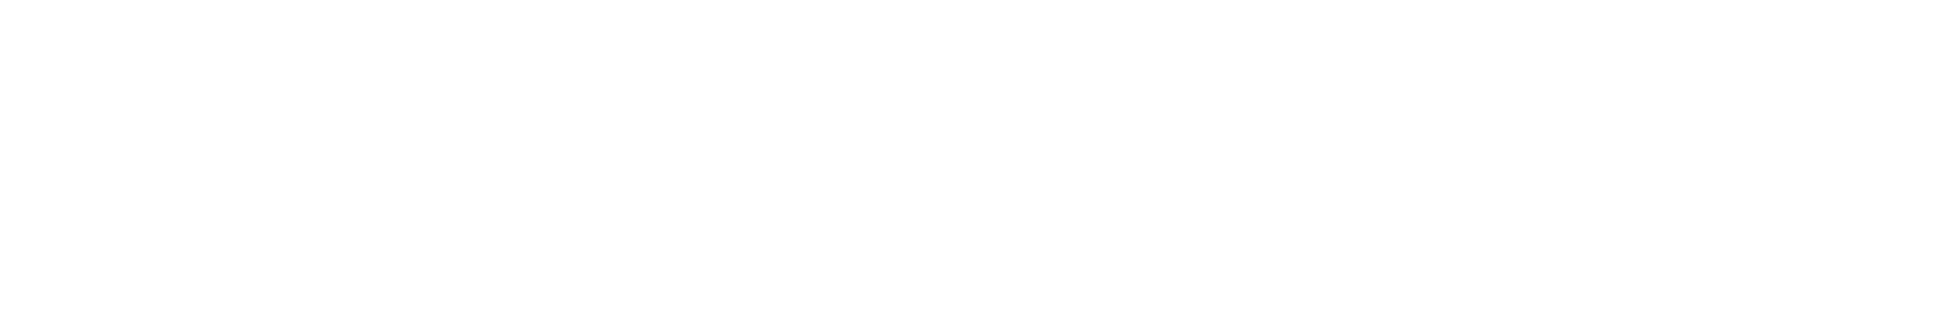

In [22]:
# Plot half-turn and strand properties
f = plt.figure(figsize=(24,4))
plt.subplot(1, 4, 1 )
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 2)
plt.scatter(x_ave, y_ave, s=2, c=HalfTurnToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('HalfTurnToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 3)
plt.scatter(x, y, s=2, c=strandToGroup)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToGroup',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Group [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.subplot(1, 4, 4)
plt.scatter(x, y, s=2, c=strandToCoilSection)
plt.xlabel('x [m]',**selectedFont)
plt.ylabel('y [m]',**selectedFont)
plt.title('StrandToCoilSection',**selectedFont)
plt.set_cmap('jet')
cbar = plt.colorbar()
cbar.set_label('Coil Section [-]',**selectedFont)
plt.rcParams.update({'font.size': 12})
plt.axis('equal')

plt.tight_layout()

# Differential inductance versus current (Iron-yoke effect)

<IPython.core.display.Javascript object>


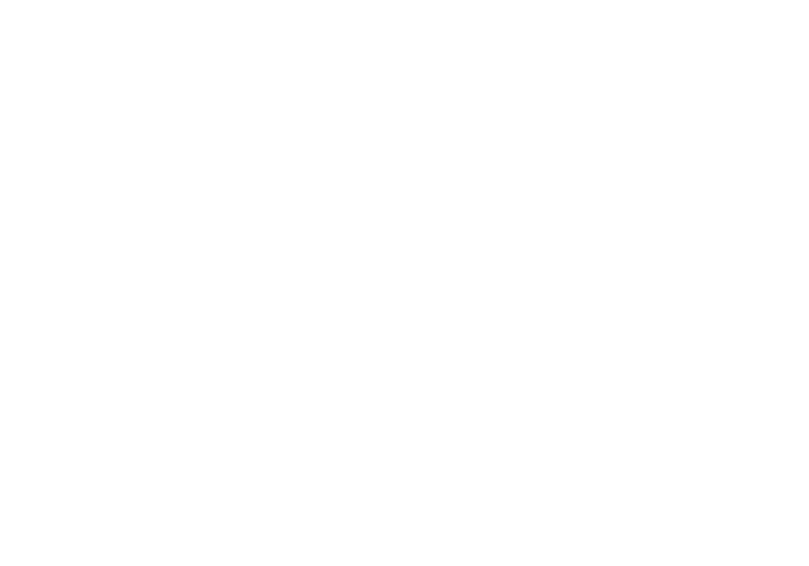

In [23]:
# Copy/paste the values after calculation using ROXIE or COMSOL or another software

fL_I = [3.60E+00,3.60E+00,3.60E+00, 1.83E+02, 3.63E+02, 5.43E+02, 7.23E+02, 9.03E+02, 1.08E+03, 1.26E+03, 1.44E+03, 1.62E+03, 1.80E+03, 1.98E+03, 2.16E+03, 2.34E+03, 2.52E+03, 2.70E+03, 2.88E+03, 3.06E+03, 3.24E+03, 3.42E+03, 3.60E+03, 3.78E+03, 3.96E+03, 4.14E+03, 4.32E+03, 4.50E+03, 4.68E+03, 4.86E+03, 5.04E+03, 5.22E+03, 5.40E+03, 10.40E+03]

fL_L = [1.128895341, 1.128895341,1.125363959, 1.125331444, 1.125290597, 1.125268715, 1.125259146, 1.125287328, 1.125245979, 1.125265133, 1.125161101, 1.125033713, 1.124874146, 1.123830429, 1.122981404, 1.120223525, 1.116055235, 1.110679173, 1.102699042, 1.089870473, 1.072712563, 1.061392556, 1.053048019, 1.045733468, 1.03993016, 1.035723516, 1.032177873, 1.029283103, 1.026714957, 1.024438253, 1.022323455, 1.020006439, 1.020006439,1]
# print(len(fL_I))
# print(len(fL_L))
# Checks
if len(fL_I) != len(fL_L):
    raise Exception('Variable fL_I should have fL_L elements. fL_I should have {} elements.'.format(fL_L))

# Plot
f = plt.figure(figsize=(10,7))
plt.plot(fL_I, fL_L, 'ro-')
plt.xlabel('Current [A]',**selectedFont)
plt.ylabel('Factor scaling nominal inductance [-]',**selectedFont)
plt.title('Differential inductance versus current',**selectedFont)
plt.xlim([0, I00*2])
plt.grid(True)
plt.rcParams.update({'font.size': 12})

# Time Vector Definition

In [24]:
# Time Vector Definition. Parameters used to generate the time vector.
# Each triplet of numbers defines a time window: first element is the start time, second element is the time step in that window, third element is the end time. It must contain a number of elements multiple of 3. Any time point above t=1000 s will be ignored.
time_vector_params = [-0.0150, 1.00E-3, -0.001,
                       -0.001+1.00E-6, 1.00E-6, 7.0E-3,
                       7.0E-3+ 1.00E-5,  1.00E-5, 1.0E-1,
                       1.0E-1+ 5.0E-4, 5.0E-4, 2]
 
# Plot
plt.plot([t_PC,t_PC], [0,1], 'k--', linewidth=4.0, label='t_PC')
plt.plot([tEE,tEE], [0,1], 'r--', linewidth=4.0, label='t_EE')
plt.plot([tCLIQ,tCLIQ], [0,1], 'g--', linewidth=4.0, label='t_CLIQ')
plt.plot([np.min(tQH),np.min(tQH)], [0,1], 'b:', linewidth=2.0, label='t_QH')
plt.xlabel('Time [s]',**selectedFont)
plt.ylabel('Trigger [-]',**selectedFont)
plt.xlim([1E-4,time_vector_params[-1]])
plt.title('Power suppply and quench protection triggers',**selectedFont)
plt.grid(True)
plt.rcParams.update({'font.size': 12})
plt.legend(loc='best')

# Options - Change something only if you know what you're doing

In [25]:
# Field-Map Files Options
Iref = I00
flagIron = 1
flagSelfField = 1
headerLines = 1
columnsXY = [4, 5]
columnsBxBy = [6, 7]
flagPlotMTF = 0

# Input Generation Options
flag_calculateInductanceMatrix = 0
flag_useExternalInitialization = 0
flag_initializeVar = 0

# Simulation Run Options
flag_fastMode = 1
flag_controlCurrent = 0
flag_automaticRefinedTimeStepping = 1

# Simulation Physics Options
flag_IronSaturation = 1
flag_InvertCurrentsAndFields = 0
flag_ScaleDownSuperposedMagneticField = 1
flag_HeCooling = 2
fScaling_Pex = 1
fScaling_Pex_AlongHeight = fScaling_Pex_AlongHeight_Defined
fScaling_MR = 1
flag_scaleCoilResistance_StrandTwistPitch = 2
flag_separateInsulationHeatCapacity = 0
flag_ISCL = 1
fScaling_Mif = 1
fScaling_Mis = 1
flag_StopIFCCsAfterQuench = 0
flag_StopISCCsAfterQuench = 0
tau_increaseRif = 0.01
tau_increaseRis = 0.01
fScaling_RhoSS = 1.09
maxVoltagePC = 10
flag_symmetricGroundingEE = 0
flag_removeUc = 0
BtX_background = 0
BtY_background = 0

# Post-Processing Options
flag_showFigures = 0
flag_saveFigures = 0
flag_saveMatFile = 1
flag_saveTxtFiles = 0
flag_generateReport = 1
flag_hotSpotTemperatureInEachGroup = 1
MinMaxXY_MTF = [-160, 160, -160, 160]

# Define the values of all Plots variables - Change something only if you know what you're doing

In [26]:
# Define the values of all Plots variables
suffixPlot = []
typePlot = []
outputPlotSubfolderPlot = []
variableToPlotPlot = []
selectedStrandsPlot = []
selectedTimesPlot = []
labelColorBarPlot = []
minColorBarPlot = []
maxColorBarPlot = []
MinMaxXYPlot = []
flagSavePlot = []
flagColorPlot = []
flagInvisiblePlot = []

# Define the values of all Variables variables - Change something only if you know what you're doing

In [27]:
# Define the values of all Variables variables
variableToSaveTxt = ['time_vector', 'Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH', 'time_vector', 'R_CoilSections', 'U_inductive_dynamic_CoilSections']
typeVariableToSaveTxt = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1]
variableToInitialize = ['Ia', 'Ib', 'T_ht', 'dT_dt_ht', 'flagQ_ht', 'IifX', 'IifY', 'Iis', 'dIifXDt', 'dIifYDt', 'dIisDt', 'Uc', 'U_QH', 'T_s_QH']

# Add all Inputs, Options, Plots, and Variables variables to a list - DO NOT CHANGE

In [28]:
# Load default LEDET variable descriptions
paramLEDET = ParametersLEDET()
# Add all Inputs variables to a list - DO NOT CHANGE
paramLEDET.addVariablesInputs(
    T00, l_magnet, I00, M_m,
    fL_I, fL_L,
    GroupToCoilSection, polarities_inGroup, nT,
    nStrands_inGroup, l_mag_inGroup, ds_inGroup,
    f_SC_strand_inGroup, f_ro_eff_inGroup, Lp_f_inGroup,
   RRR_Cu_inGroup,
    SCtype_inGroup, STtype_inGroup, insulationType_inGroup,
    internalVoidsType_inGroup,
    externalVoidsType_inGroup,
    wBare_inGroup, hBare_inGroup, wIns_inGroup, hIns_inGroup,
    Lp_s_inGroup, R_c_inGroup,
    Tc0_NbTi_ht_inGroup, Bc2_NbTi_ht_inGroup,
    c1_Ic_NbTi_inGroup, c2_Ic_NbTi_inGroup,
    Tc0_Nb3Sn_inGroup, Bc2_Nb3Sn_inGroup, Jc_Nb3Sn0_inGroup,
    el_order_half_turns,
    alphasDEG, rotation_block, mirror_block, mirrorY_block,
    iContactAlongWidth_From, iContactAlongWidth_To,
    iContactAlongHeight_From,
    iContactAlongHeight_To,
    iStartQuench, tStartQuench, lengthHotSpot_iStartQuench,
    vQ_iStartQuench,
    R_circuit, R_crowbar, Ud_crowbar, t_PC, t_PC_LUT, I_PC_LUT,
    tEE, R_EE_triggered,
    tCLIQ, directionCurrentCLIQ, nCLIQ, U0, C, Rcapa,
    tQH, U0_QH, C_QH, R_warm_QH, w_QH, h_QH, s_ins_QH, type_ins_QH,
    s_ins_QH_He, type_ins_QH_He, l_QH, f_QH,
    iQH_toHalfTurn_From, iQH_toHalfTurn_To,
    tQuench, initialQuenchTemp,
    HalfTurnToInductanceBlock, M_InductanceBlock_m
)
 
# Add all Options variables to a list - DO NOT CHANGE
paramLEDET.addVariablesOptions(
    time_vector_params,
    Iref, flagIron, flagSelfField, headerLines, columnsXY, columnsBxBy, flagPlotMTF,
    flag_calculateInductanceMatrix, flag_useExternalInitialization, flag_initializeVar,
    flag_fastMode, flag_controlCurrent, flag_automaticRefinedTimeStepping, flag_IronSaturation,
    flag_InvertCurrentsAndFields, flag_ScaleDownSuperposedMagneticField, flag_HeCooling, fScaling_Pex, fScaling_Pex_AlongHeight,
    fScaling_MR, flag_scaleCoilResistance_StrandTwistPitch, flag_separateInsulationHeatCapacity,
    flag_ISCL, fScaling_Mif, fScaling_Mis, flag_StopIFCCsAfterQuench, flag_StopISCCsAfterQuench, tau_increaseRif, tau_increaseRis,
    fScaling_RhoSS, maxVoltagePC, flag_symmetricGroundingEE, flag_removeUc, BtX_background, BtY_background,
    flag_showFigures, flag_saveFigures, flag_saveMatFile, flag_saveTxtFiles, flag_generateReport,
    flag_hotSpotTemperatureInEachGroup, MinMaxXY_MTF
)
 
# Define the values of all Plots variables - DO NOT CHANGE
paramLEDET.addVariablesPlots(
    suffixPlot, typePlot, outputPlotSubfolderPlot, variableToPlotPlot, selectedStrandsPlot, selectedTimesPlot,
    labelColorBarPlot, minColorBarPlot, maxColorBarPlot, MinMaxXYPlot, flagSavePlot, flagColorPlot, flagInvisiblePlot
)
 
# Define the values of all Variables variables - DO NOT CHANGE
paramLEDET.addVariablesVariables(
    variableToSaveTxt, typeVariableToSaveTxt, variableToInitialize
)


#Visualize the defined variables

In [29]:
if verbose:
    # Visualize variable descriptions, names, and values
    print('### "Inputs" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupInputs, paramLEDET.variablesInputs)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Options" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupOptions, paramLEDET.variablesOptions)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Plots" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupPlots, paramLEDET.variablesPlots)

    # Visualize variable descriptions, names, and values
    print('')
    print('### "Variables" variables ###')
    paramLEDET.printVariableDescNameValue(paramLEDET.variableGroupVariables, paramLEDET.variablesVariables)

### "Inputs" variables ###
Initial temperature [K]
T00 4.5
Magnetic length [m]
l_magnet 3.4
Initial current [A]
I00 3610
Define the coil section where each group of cables is located
GroupToCoilSection [2, 2, 4, 4, 4, 1, 1, 3, 3, 3, 4, 4, 2, 2, 2, 3, 3, 1, 1, 1, 6, 6, 8, 8, 8, 5, 5, 7, 7, 7, 8, 8, 6, 6, 6, 7, 7, 5, 5, 5, 2, 2, 4, 4, 4, 1, 1, 3, 3, 3, 4, 4, 2, 2, 2, 3, 3, 1, 1, 1, 6, 6, 8, 8, 8, 5, 5, 7, 7, 7, 8, 8, 6, 6, 6, 7, 7, 5, 5, 5]
Polarity of the current in each group of strands
polarities_inGroup [1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, 1]
Number of half-turns in each group
nT [20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16, 20, 17, 15, 6, 16


#Write the LEDET input file

In [30]:
nameFileLEDET = nameMagnet + '_0' + '.xlsx'
paramLEDET.writeFileLEDET(nameFileLEDET)

You're using a time, that is before the start of the simulation. Corrected Time-Vector.
Preliminary consistency check was successful! -  MQY_8Coils_0.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-27 18:13:18.888263
New file MQY_8Coils_0.xlsx generated.


# Persistent Currents

<IPython.core.display.Javascript object>


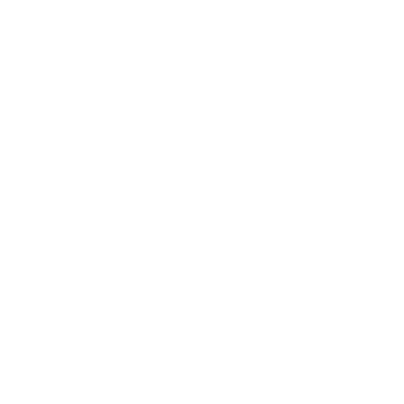

Preliminary consistency check was successful! -  MQY_8Coils_200.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-27 18:13:26.636766
New file MQY_8Coils_200.xlsx generated.


In [31]:
# This cell writes an input file for simulating a powering cycle
# Define input parameters 
I00 = 3610 # Amplitude of powering current Ia. Default: nominal current  
# LUT controlling power supply for powering cycle , Current [A]. Two cycles of ramping from 0 to I00 to negative I00 and back to 0. 
I_PC_LUT = [0, 0, I00, I00, 0, 0, I00, I00, 0]
dIdt = 10.833   # Current ramp rate 
timeStep = 0.025  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_200' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)

<IPython.core.display.Javascript object>


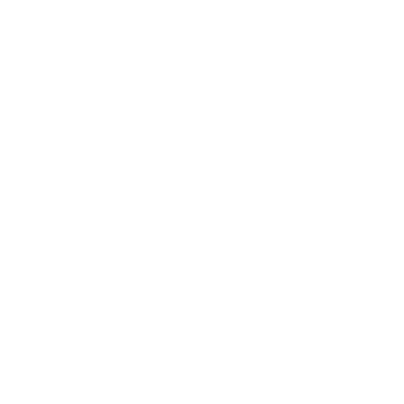

Preliminary consistency check was successful! -  MQY_8Coils_220.xlsx

### Write "Variables" sheet ###

### Write "Plots" sheet ###

### Write "Options" sheet ###
### Write "Inputs" sheet ###
 
Time stamp: 2021-07-27 18:13:34.419926
New file MQY_8Coils_220.xlsx generated.


In [32]:
# This cell writes an input file for simulating a powering cycle - this ramps from 0 to  100 A and back followed by a cycle where the current reaches nominal current. 
# Define input parameters 
I00 = 3610 # Amplitude of powering current Ia. Default: nominal current  
# LUT controlling power supply for powering cycle , Current [A]. Two cycles of ramping from 0 to I00 to negative I00 and back to 0. 
I_PC_LUT = [0, 0, 100, 100, 0, 0, I00, I00, 0]
dIdt = 10.833   # Current ramp rate 
timeStep = 0.025  # Coarse time step

# Write input file to LEDET
nameFileLEDET_PS = nameMagnet + '_220' + '.xlsx'
PS_paramLEDET = deepcopy(paramLEDET)
PS_paramLEDET.localsParser(locals())
PS_paramLEDET.preparePersistentCurrents(I_PC_LUT, dIdt, timeStep)
PS_paramLEDET.writeFileLEDET(nameFileLEDET_PS)